In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [0]:
true_probs = np.load('distribution.npy')

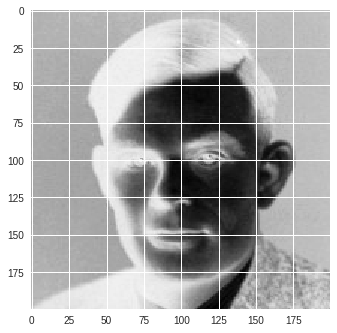

In [0]:
plt.imshow(true_probs)

In [0]:
samples = np.random.choice(200 * 200, p=true_probs.reshape(-1), size=100000)
samples_x = samples % 200
samples_y = samples // 200
samples = np.stack([samples_x, samples_y], axis=1)
train, val = train_test_split(samples, test_size=0.2)

In [0]:
tf.reset_default_graph()
sess = tf.Session()

thetas = tf.Variable(np.zeros(200), dtype=tf.float32, name='thetas', trainable=True)
ps = tf.exp(thetas) / tf.reduce_sum(tf.exp(thetas))

input_data = tf.placeholder(dtype=tf.int32, shape=(None, 2))
training = tf.placeholder(dtype=tf.bool)

x1s = input_data[:, 0]
x2s = input_data[:, 1]

output = tf.layers.dense(inputs=tf.one_hot(x1s, depth=200), 
                         units=200, 
                         activation='relu', 
                         use_bias=True,
                         kernel_initializer=tf.initializers.glorot_normal(),
                         bias_initializer=tf.initializers.glorot_normal())

output = tf.layers.dropout(inputs=output, training=training, rate=0.7)

output = tf.layers.dense(inputs=output, units=200, activation='softmax',
                         use_bias=True,
                         kernel_initializer=tf.initializers.glorot_normal(),
                         bias_initializer=tf.initializers.glorot_normal())

p_x1 = tf.gather(ps, x1s)
p_x2_x1 = tf.gather_nd(output, tf.stack([tf.range(tf.shape(input_data)[0]), x2s], axis=1))
final_prob = p_x1 * p_x2_x1

loss = tf.reduce_mean(-tf.log(p_x1) - tf.log(p_x2_x1))
loss *= np.log2(np.e)

In [0]:
opt = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = opt.minimize(loss)
sess.run(tf.global_variables_initializer())

In [0]:
train_losses = []
val_losses = []

batch_size = 10

for i in range(40001):
    sample_batch = np.random.choice(len(train), size=batch_size)
    sample_batch = train[sample_batch]
    _, train_loss = sess.run([train_step, loss],
                            feed_dict={input_data: sample_batch,
                                      training: True})
    train_losses.append(train_loss)
    
    if i % 100 == 0:
        val_losses.append(np.mean(sess.run(loss, {input_data: val,
                                                 training: False})))
    
    print('\rStep {}\ttrain_loss: {}\tval_loss: {}'.format(i,
                                                           train_losses[-1],
                                                           val_losses[-1]), end='')

Step 40000	train_loss: 14.86255931854248	val_loss: 15.234660148620605

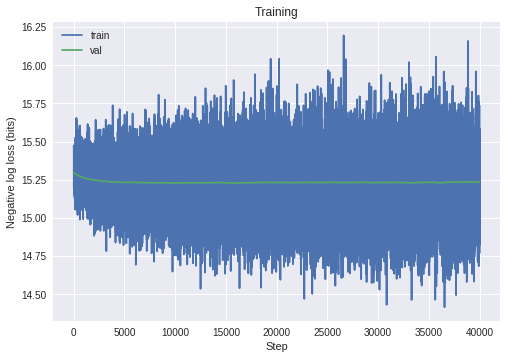

In [0]:
plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot(np.arange(0, len(val_losses) * 100, 100), val_losses, label='val')
plt.title('Training')
plt.xlabel('Step')
plt.ylabel('Negative log loss (bits)')
plt.legend()
plt.grid(True)

In [0]:
all_datapoints = [(x, y) for x in range(200) for y in range(200)]
final_ps = sess.run(final_prob, {input_data: all_datapoints, training: False}).reshape((200, 200))

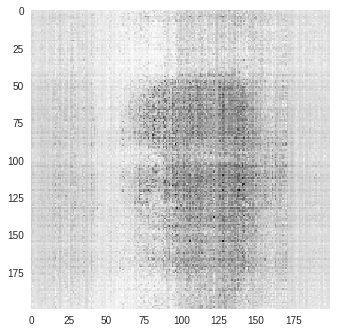

In [0]:
plt.imshow(final_ps.reshape((200, 200)).T)
plt.grid(False)

In [0]:
def sample_from_model(count):
    samples = np.random.choice(200**2, p=final_ps.reshape(-1), size=count)
    return np.stack([samples // 200, samples % 200], axis=1)

In [0]:
s = sample_from_model(1000000)

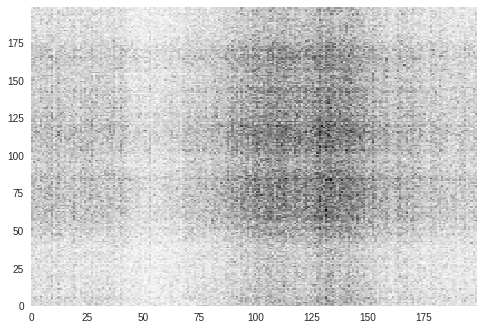

In [0]:
plt.hist2d(s[:, 0], s[:, 1], bins=200);